# Two Stream Generation 
### Backgroun + Foreground
#### Reference: MIT Generating Video with Scene Dynamics[http://web.mit.edu/vondrick/tinyvideo/]

In [1]:
from util import *
from util.parser import *
from util.img_kit import *
from util.tf_ops import *
from util.notebook_display import *
from util.numeric_ops import *
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
img_collections = get_processed_moving_box()
# number of images for each collection
num_per_collection = [x.shape[0] for x in img_collections]
# number of collections
n_collection = len(img_collections)
# total number of images
total_imgs = sum(num_per_collection)
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(n_collection, total_imgs))

{'dim': (50, 32, 32), 'images:': 'triangle'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (56, 32, 32), 'images:': 'trangle-vertical'}
{'dim': (56, 32, 32), 'images:': 'circle-diagnal'}
{'dim': (56, 32, 32), 'images:': 'square-diagnal-2'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (56, 32, 32), 'images:': 'square-vertical-2'}
{'dim': (56, 32, 32), 'images:': 'trangle-vertical-3'}
{'dim': (56, 32, 32), 'images:': 'trangle-horizontal'}
{'dim': (56, 32, 32), 'images:': 'square-vertical-3'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (56, 32, 32), 'images:': 'trangle-vertical-2'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (14, 32, 32), 'images:': 'moving box uniform'}
{'dim': (56, 32, 32), 'images:': 'circle'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (56, 32, 32), 'images:': 'rectangle'}
{'dim': (56, 32, 32), 'images:': 'circle-diagnal-2'}
{'dim': (56, 32, 32), 'images:': 'square-vertical'}


In [3]:
train_ind_collection, val_ind_collection = zip(*[split_train_dev(x) for x in img_collections])

In [4]:
def sample(batch_size = 8, train=True, gap = 1):
    # get average number of training for each class
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i in range(n_collection):
        data = train_ind_collection[i] if train else val_ind_collection[i]
        try:
            s = np.random.choice(list(filter(lambda x:x<num_per_collection[i]-gap-1, data)),avg_num_per_class, replace=False)
            before_ind.append(s)
        except:
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+gap+1 for x in before_ind]
    # mid-index for each class
    mid_ind = [x+(gap+1)//2 for x in before_ind]
    
    selected_classed = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([img_collections[i][before_ind[i]] for i in selected_classed], axis = 0)
    after_imgs = np.concatenate([img_collections[i][after_ind[i]] for i in selected_classed], axis = 0)
    mid_imgs = np.concatenate([img_collections[i][mid_ind[i]] for i in selected_classed], axis = 0)
    
    clipped = np.random.choice(range(before_imgs.shape[0]), batch_size, replace=False)
    before_imgs = before_imgs[clipped]
    mid_imgs = mid_imgs[clipped]
    after_imgs = after_imgs[clipped]
    return (before_imgs, after_imgs), mid_imgs

In [5]:
def sample_train(batch_size = 8, gap = 1):
    return sample(batch_size)
def sample_dev(batch_size = 8, gap = 1):
    return sample(batch_size, False, gap)

## Take a look at input data

Before: (4, 32, 32)
After:  (4, 32, 32)
Mid:    (4, 32, 32)


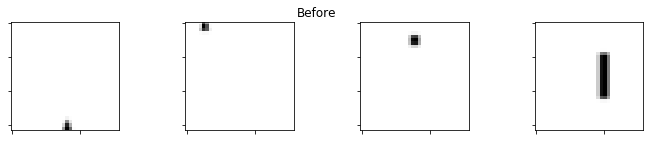

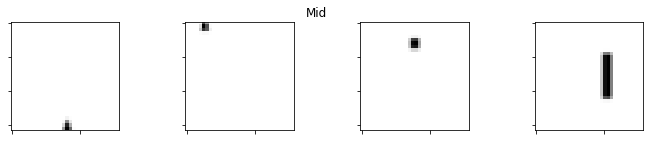

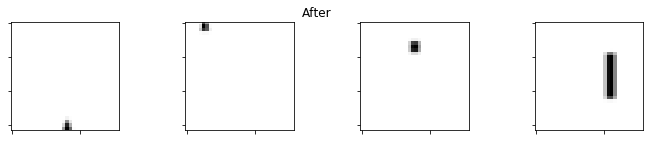

In [6]:
(test_before, test_after), test_mid = sample_train(4)
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
size = (12, 2)
plot_images(test_before, size, "Before")
plot_images(test_mid, size, "Mid")
plot_images(test_after, size, "After")

In [7]:
def content_loss(x, gd):
    x, gd = tf.contrib.layers.flatten(x), tf.contrib.layers.flatten(gd)
    return tf.norm(x-gd)

## Extract Background

In [33]:
def extract_background(x, is_training=True):
    x = tf.layers.conv2d(x, filters = 32, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)
    
    x = tf.contrib.layers.flatten(x)
    x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, training=is_training)
    
    x = tf.reshape(x, [-1, 32, 32, 1])
    x = tf.layers.conv2d(x, filters = 32, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)
    
    x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.tanh, padding='same')
    x = tf.reshape(x, [-1, 32, 32, 1])
    return x

## Generator

In [45]:
def generate(x1, x2,  is_training=True):
    """
    Input:
        x1, x2: batch size of images for inference
    Output:
        predicted images of batch size
    """
    with tf.variable_scope("generator"):
        # reshape and concatenate
        x1 = tf.reshape(x1, [-1,  32, 32, 1])
        x2 = tf.reshape(x2, [-1,  32, 32, 1])
        x = tf.concat([(x1+x2)/2, (x2-x1)], axis=3)
        
        background= extract_background(x, is_training)
        print(tf.shape(background))
        
        x = tf.layers.conv2d(x, filters = 128, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        
        x = tf.layers.dense(x, 8*8*128, activation=tf.nn.relu)
        x = tf.reshape(x, [-1, 8, 8, 128])
        
        x = tf.layers.conv2d(x, filters = 32, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')
        x = tf.layers.batch_normalization(x,  axis=3, training=is_training)
        
        ####### split into Mask and Foreground  ####### 
        # Foreground - relu activation
        fg = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(4, 4),  strides=(2, 2), activation=tf.nn.tanh, padding='same')
        fg = tf.reshape(fg, [-1, 32, 32, 1])
        # Mask
        mask = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.sigmoid, padding='same')
        mask = tf.reshape(mask, [-1, 32, 32, 1])
        
        # Assemble background, foreground, and mask into final image
        print(mask.get_shape())
        img = mask * fg + (1-mask) * background
        return img

In [46]:
def get_generattion(before, after, mid):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    gen_batch, loss = sess.run([G_batch, G_loss], dic)
    return gen_batch, loss

### Model Param

In [47]:
gap = 1
batch_size = 16

learning_rate = 2e-4
beta = 0.9
num_iteration = 4000
relu_alpha = 0.01

In [48]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32])
batch_before     = tf.placeholder(tf.float32, [None, 32, 32])
batch_after      = tf.placeholder(tf.float32, [None, 32, 32])
is_training      = tf.placeholder(tf.bool, ())

G_batch = generate(batch_before, batch_after)

G_loss = content_loss(G_batch, batch_mid)
_, G_solver = get_solvers_adam(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

Tensor("generator/Shape:0", shape=(4,), dtype=int32)
(?, 32, 32, 1)


In [49]:
def train(sess, G_step, G_loss, batch_size, num_iteration, plot_every = 400, show_loss_every=400, nPlot=6):
    g_losses = []
    for i in range(num_iteration):
        (real_before, real_after), real_mid = sample_train(batch_size, gap)
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        print(batch_mid)
        g_losses.append(G_loss_curr)
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {}".format(i, G_loss_curr))
            
        if i%plot_every == 0:
            gen_batch_test = sess.run(G_batch, feed_dict=\
                                      {batch_before: real_before, batch_after: real_after, is_training: False})
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {}".format(i))
    return g_losses

## Train !

In [50]:
sess = get_session()
sess.run(tf.global_variables_initializer())
g_loss = train(sess, G_train_step, G_loss, batch_size, num_iteration, plot_every = 400)

InvalidArgumentError: Incompatible shapes: [1024,32,32,1] vs. [16,32,32,1]
	 [[Node: generator/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](generator/Reshape_6, generator/Reshape_5)]]
	 [[Node: norm/Squeeze/_39 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2757_norm/Squeeze", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'generator/mul', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-f492782523a9>", line 7, in <module>
    G_batch = generate(batch_before, batch_after)
  File "<ipython-input-45-ab3ddbe0ee49>", line 46, in generate
    img = mask * fg + (1-mask) * background
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 794, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 1015, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1625, in _mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [1024,32,32,1] vs. [16,32,32,1]
	 [[Node: generator/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](generator/Reshape_6, generator/Reshape_5)]]
	 [[Node: norm/Squeeze/_39 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2757_norm/Squeeze", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
figsize = (8, 2)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses")
plt.show()